## TriBoost Churn Prediction Performance Analysis

### 1. Imports & Plotting Configuration

This cell imports the essential Python libraries used throughout the notebook (pandas, matplotlib, seaborn, scikit-learn utilities, joblib, and system/os helpers). It also sets plotting styles and updates matplotlib's DPI to improve figure resolution. Keeping plotting configuration in a dedicated cell makes it easy to change visuals globally.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from joblib import load
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc,
    precision_recall_curve, average_precision_score, brier_score_loss
)
from sklearn.model_selection import cross_val_score
from sklearn.calibration import calibration_curve
from sklearn.base import clone
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)
from config import X_TEST_PATH, Y_TEST_PATH, MODEL_PATH, Y_TRAIN_PATH, X_TRAIN_PATH

plt.style.use("default")
sns.set_palette("husl")
sns.set_style("whitegrid")
plt.rcParams.update({
    "figure.dpi": 150
})

### 2. Load Test Data & Model

This cell loads the test data (x_test, y_test) and the trained model from disk using the paths defined in a config module.

In [2]:
x_test = pd.read_csv(X_TEST_PATH)
y_test = pd.read_csv(Y_TEST_PATH).values.ravel()
model = load(MODEL_PATH)

print(f"Test Set Loaded: {x_test.shape[0]:,} customers, {x_test.shape[1]} features")
print(f"Target Distribution in Test Set → Loyal: {(y_test == 0).sum():,}, Churn: {(y_test == 1).sum():,}")
print("Model: XAI-Churn TriBoost (XGBoost + CatBoost + LightGBM Soft Voting Ensemble)")

Test Set Loaded: 861,620 customers, 9 features
Target Distribution in Test Set → Loyal: 700,025, Churn: 161,595
Model: XAI-Churn TriBoost (XGBoost + CatBoost + LightGBM Soft Voting Ensemble)


### 3. Model Predictions & Basic Metrics

This cell uses the loaded model to produce predicted class labels (y_pred) and churn probabilities (y_prob). It computes and prints the primary classification metrics: Accuracy, Precision, Recall, and F1-score.

In [3]:
y_pred = model.predict(x_test)
y_prob = model.predict_proba(x_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall   : {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score : {f1:.4f} ({f1*100:.2f}%)")

Accuracy : 0.8499 (84.99%)
Precision: 0.5778 (57.78%)
Recall   : 0.7412 (74.12%)
F1-Score : 0.6494 (64.94%)


### 4. Classification Report & Confusion Matrix Visualization

This cell prints a detailed classification report (precision, recall, f1 per class) and plots a confusion matrix heatmap. Visualization helps to quickly understand the types of errors (false positives vs false negatives) the model makes.

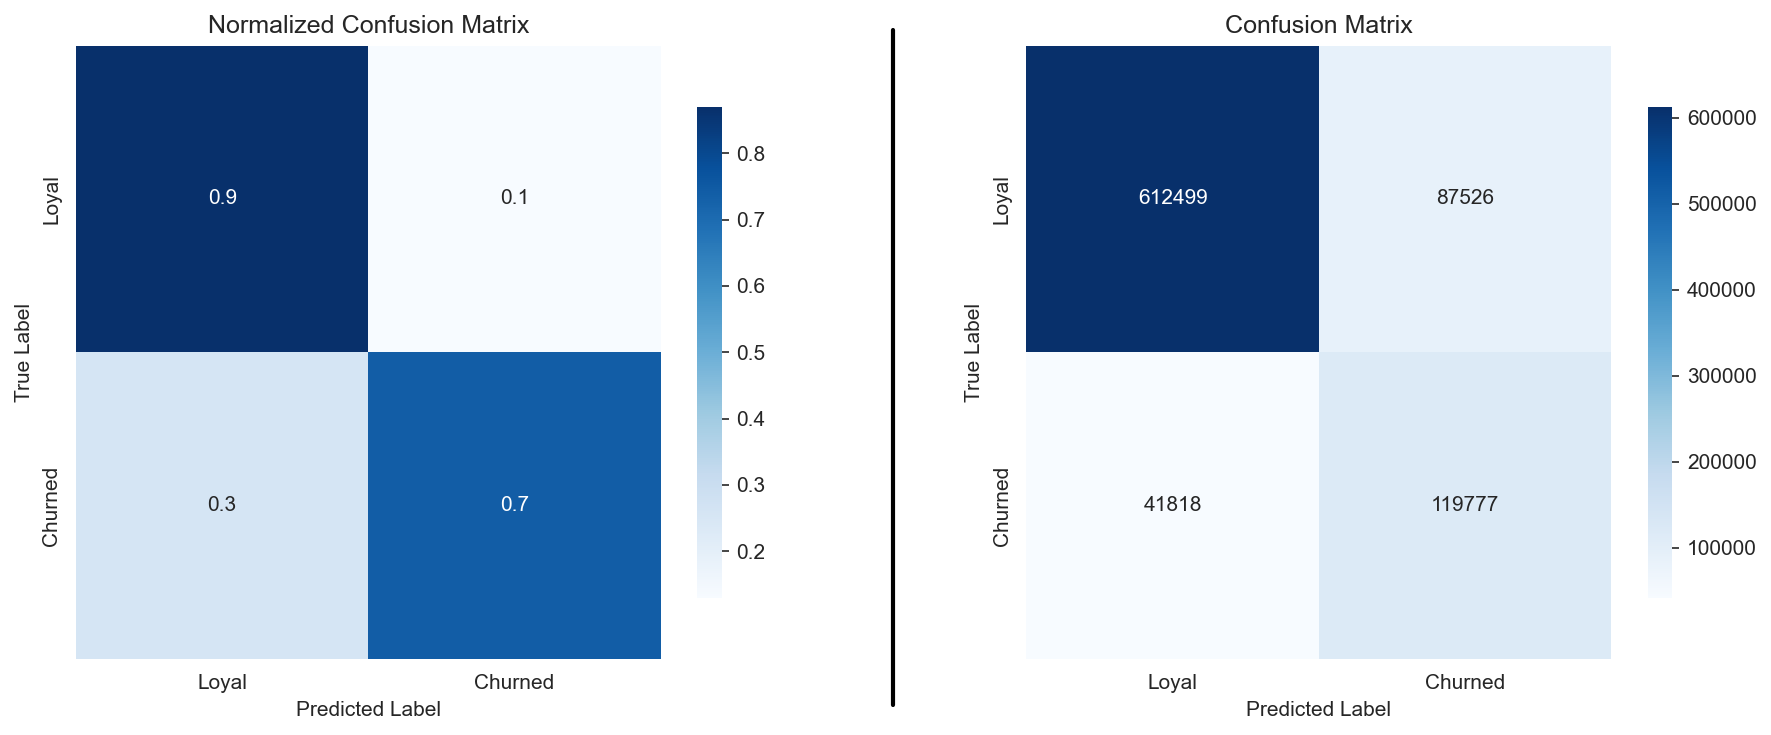

Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.87      0.90    700025
           1       0.58      0.74      0.65    161595

    accuracy                           0.85    861620
   macro avg       0.76      0.81      0.78    861620
weighted avg       0.87      0.85      0.86    861620



In [4]:
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.round(cm_normalized, 2)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(
    cm_normalized, 
    annot=True,
    fmt=".1f", 
    cmap="Blues",
    xticklabels=["Loyal", "Churned"],
    yticklabels=["Loyal", "Churned"],
    cbar_kws={"shrink": 0.8}
)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.subplot(1, 2, 2)
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=["Loyal", "Churned"],
    yticklabels=["Loyal", "Churned"],
    cbar_kws={"shrink": 0.8}
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

plt.gcf().add_artist(
    plt.Line2D(
        [0.5, 0.5],   
        [0.05, 0.95], 
        color="black",
        linewidth=2
    )
)

plt.tight_layout()
plt.subplots_adjust(wspace=0.3) 
plt.show()

print(f"Classification Report: \n{classification_report(y_test, y_pred)}")

### 5. Confusion Matrix Breakdown

This cell extracts the confusion matrix components (tn, fp, fn, tp) and prints a clear, human-readable breakdown of counts and percentages for correct vs incorrect predictions and each confusion cell. This is useful to communicate exact error numbers.

In [5]:
tn, fp, fn, tp = cm.ravel()

total_samples   = len(y_test)
correct_total   = tn + tp
incorrect_total = fp + fn

print(f"Total customers evaluated: {total_samples:,}")
print(f"Correctly predicted: {correct_total:,} ({correct_total / total_samples:.2%})")
print(f"Incorrectly predicted: {incorrect_total:,} ({incorrect_total / total_samples:.2%})")
print(f"Actual Loyal → Predicted Loyal: {tn:,}  (True Negative)")
print(f"Actual Loyal → Predicted Churn: {fp:,}  (False Positive)")
print(f"Actual Churn → Predicted Loyal: {fn:,}  (False Negative)")
print(f"Actual Churn → Predicted Churn: {tp:,}  (True Positive)")

Total customers evaluated: 861,620
Correctly predicted: 732,276 (84.99%)
Incorrectly predicted: 129,344 (15.01%)
Actual Loyal → Predicted Loyal: 612,499  (True Negative)
Actual Loyal → Predicted Churn: 87,526  (False Positive)
Actual Churn → Predicted Loyal: 41,818  (False Negative)
Actual Churn → Predicted Churn: 119,777  (True Positive)


### 6. ROC Curve and Precision–Recall Curve

This cell computes and plots the Receiver Operating Characteristic (ROC) curve with AUC and the Precision–Recall curve with Average Precision (AP). Both plots are presented side-by-side to evaluate ranking quality and performance under different thresholds. A baseline churn rate is also displayed on the PR plot.

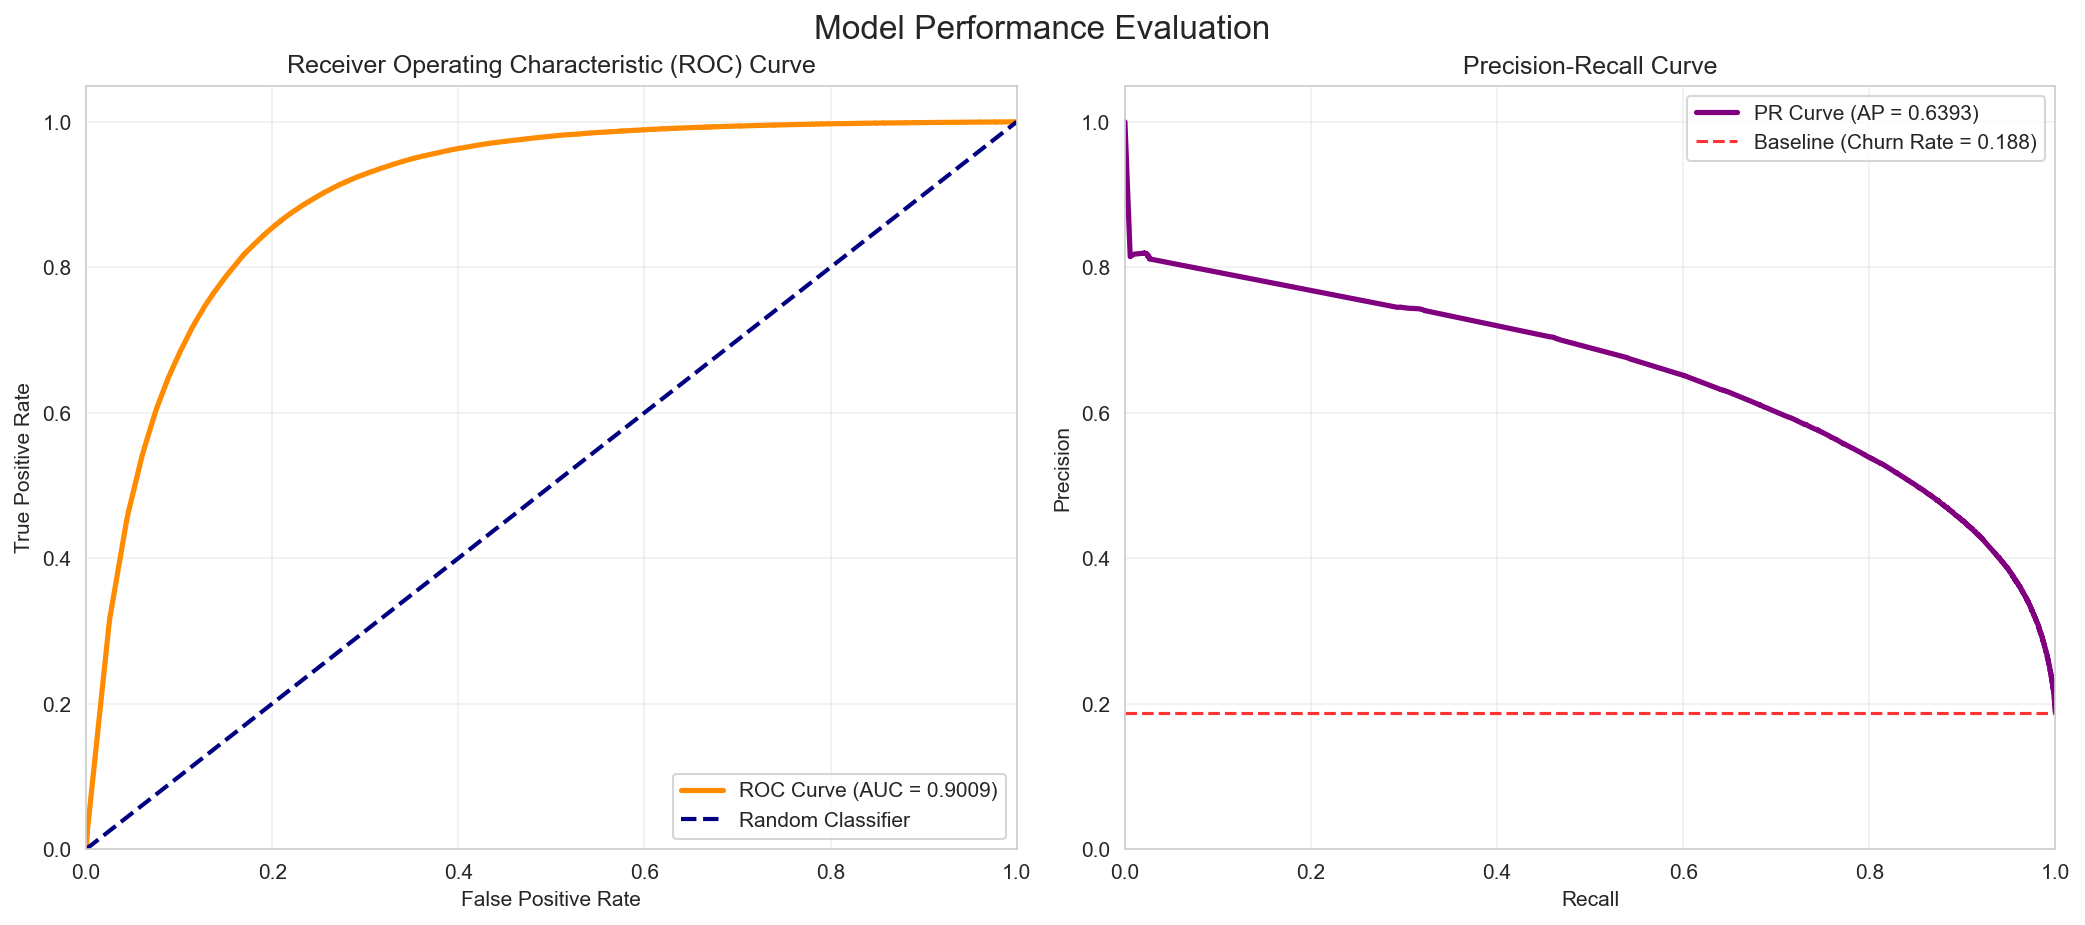

In [6]:
y_test_flat = y_test.ravel()

fpr, tpr, _ = roc_curve(y_test_flat, y_prob)
roc_auc = auc(fpr, tpr)

precision_curve, recall_curve, _ = precision_recall_curve(y_test_flat, y_prob)
pr_auc = average_precision_score(y_test_flat, y_prob)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(fpr, tpr, color="darkorange", lw=2.5, label=f"ROC Curve (AUC = {roc_auc:.4f})")
ax1.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Classifier")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title("Receiver Operating Characteristic (ROC) Curve")
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])

ax2.plot(recall_curve, precision_curve, color="purple", lw=2.5, label=f"PR Curve (AP = {pr_auc:.4f})")
ax2.axhline(y=y_test_flat.mean(), color="red", linestyle="--", alpha=0.8, label=f"Baseline (Churn Rate = {y_test_flat.mean():.3f})")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.set_title("Precision-Recall Curve")
ax2.legend(loc="upper right")
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.suptitle("Model Performance Evaluation", fontsize=16, y=1.02)
plt.show()

### 7. Predicted Probability Distribution

This cell plots histograms of predicted churn probabilities for the two true classes (Loyal vs Churn). It draws a default threshold line at 0.5 and highlights high-risk / no-risk zones. This visualization helps inspect calibration and separability of predicted probabilities.

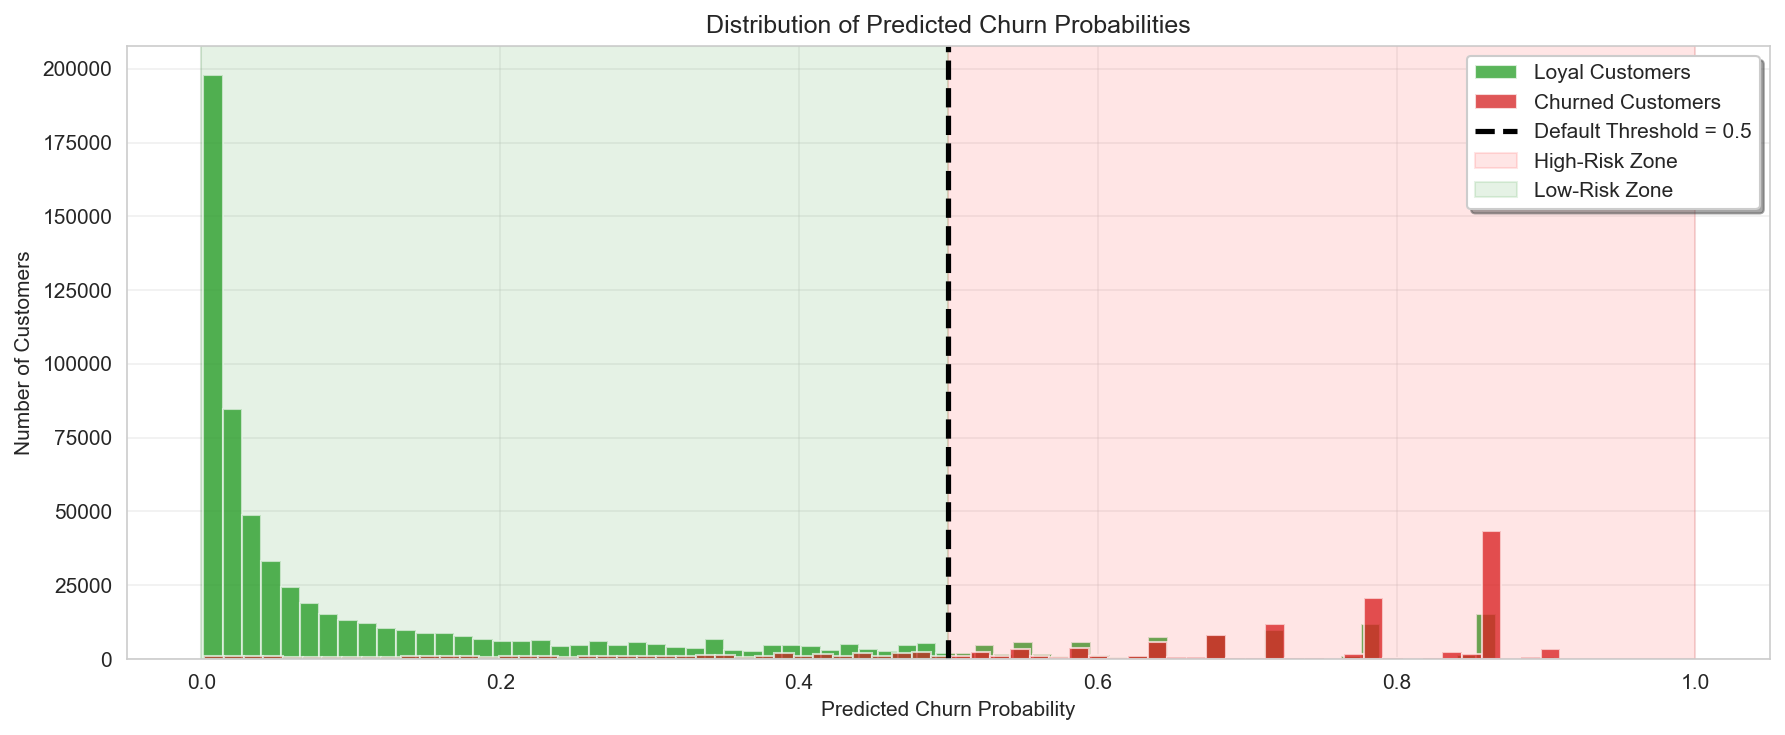

In [7]:
plt.figure(figsize=(12, 5))
plt.hist(y_prob[y_test == 0], bins=70, alpha=0.78, label="Loyal Customers", color="#2ca02c", edgecolor="white")
plt.hist(y_prob[y_test == 1], bins=70, alpha=0.78, label="Churned Customers", color="#d62728", edgecolor="white")

plt.axvline(0.5, color="black", linewidth=2.5, linestyle="--", label="Default Threshold = 0.5")
plt.axvspan(0.5, 1.0, alpha=0.1, color="red", label="High-Risk Zone")
plt.axvspan(0, 0.5, alpha=0.1, color="green", label="Low-Risk Zone")

plt.xlabel("Predicted Churn Probability")
plt.ylabel("Number of Customers")
plt.title("Distribution of Predicted Churn Probabilities")
plt.legend(frameon=True, fancybox=True, shadow=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 8. Overfitting Detection - Method 1: Train vs. Test Performance Comparison
This cell loads the training data, makes predictions using the model, and calculates the training accuracy. It then compares the training accuracy with the test accuracy.

In [8]:
x_train = pd.read_csv(X_TRAIN_PATH)
y_train = pd.read_csv(Y_TRAIN_PATH).values.ravel()

y_train_pred = model.predict(x_train)
y_train_accuracy = accuracy_score(y_train, y_train_pred)
accuracy_difference = y_train_accuracy - accuracy

print(f"Training Accuracy: {y_train_accuracy:.4f} ({y_train_accuracy*100:.2f}%)")
print(f"Test Accuracy    : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Difference (Train - Test): {accuracy_difference:.4f}")

Training Accuracy: 0.8422 (84.22%)
Test Accuracy    : 0.8499 (84.99%)
Difference (Train - Test): -0.0077


### 9. Overfitting Detection - Method 2: K-Fold Cross-Validation

This cell performs 5-fold cross-validation on the training data using the same model.
Cross-validation helps evaluate how well the model generalizes by training and testing it on different splits of the data.

In [9]:
cv_scores = cross_val_score(
    clone(model),
    x_train, 
    y_train, 
    cv=5, 
    scoring="accuracy", 
    n_jobs=-1
)

print(f"CV Scores (5 Folds): {cv_scores}")
print(f"Mean CV Accuracy   : {cv_scores.mean():.4f} ({cv_scores.mean()*100:.2f}%)")
print(f"Standard Deviation : {cv_scores.std():.4f}")

CV Scores (5 Folds): [0.83072655 0.83095194 0.84194838 0.84553238 0.84578316]
Mean CV Accuracy   : 0.8390 (83.90%)
Standard Deviation : 0.0068


### 10. Probability Quality: Calibration Curve

The Calibration Curve (or Reliability Diagram) assesses the quality and trustworthiness of the model"s predicted probabilities. The dashed black line represents perfect calibration (e.g., if the model predicts a 70% churn risk for 100 customers, exactly 70 of them should churn).

The closer the model"s curve is to this ideal line, the better the calibration. Models with proper calibration are more reliable for business decisions based on risk, such as allocating resources for retention campaigns. The Brier Score is a measure of the mean squared error of the probability predictions, where a lower score indicates better calibration.

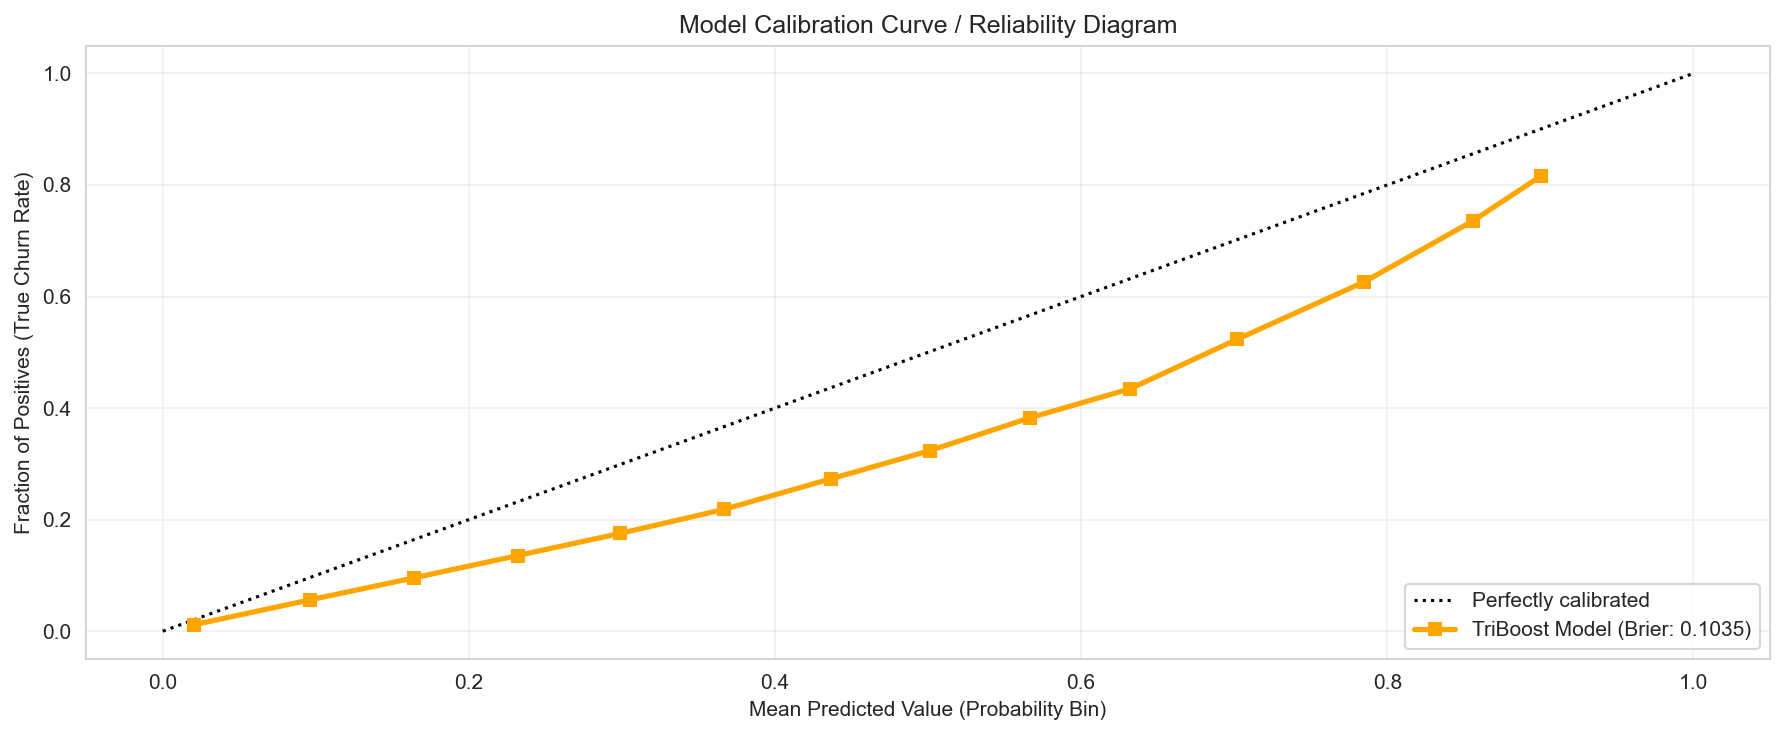

In [10]:
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob, n_bins=15)
brier_score = brier_score_loss(y_test, y_prob)

plt.figure(figsize=(12, 5))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"TriBoost Model (Brier: {brier_score:.4f})", color="orange", lw=2.5)
plt.xlabel("Mean Predicted Value (Probability Bin)")
plt.ylabel("Fraction of Positives (True Churn Rate)")
plt.title("Model Calibration Curve / Reliability Diagram")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Summary

The XAI-Churn TriBoost model (XGBoost + CatBoost + LightGBM soft-voting ensemble) was evaluated on a large test set of 861,620 customers with 9 features. The target distribution was imbalanced, with most customers labeled as loyal. 

The model achieved 84.99% accuracy, with strong recall for the churn class (74.12%), making it effective at detecting customers likely to churn. 

Precision for churn was moderate (57.78%), which means some loyal customers were misclassified as churn. Overall, the F1-score for churn reached 64.94%. 

Cross-validation showed stable performance (mean CV accuracy: 83.90%, std: 0.0068), and the small gap between training and test accuracy indicates good generalization. 

In summary, the TriBoost model provides reliable churn detection with balanced performance and no signs of overfitting.